In [1]:
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import seaborn as sns

#Sklearn imports
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report, \
roc_curve, plot_precision_recall_curve, precision_recall_curve, confusion_matrix, auc,plot_roc_curve

In [2]:
os.chdir("../data/raw")

In [3]:
df=pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [4]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount


In [5]:
df.smoking.value_counts()

0    203
1     96
Name: smoking, dtype: int64

In [6]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [7]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [8]:
df.drop(columns='time', inplace=True)

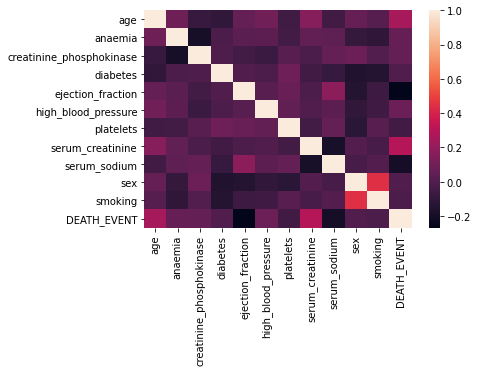

In [9]:
sns.heatmap(df.corr())
plt.show()

In [18]:
df_norm=(df-df.min())/(df.max()-df.min())
df_norm.drop(columns=['anaemia','diabetes','high_blood_pressure','sex','smoking'],inplace=True)
dict_={1:'Heart Failure',0:'Survived'}
df_norm.DEATH_EVENT=df_norm.DEATH_EVENT.map(dict_)
df_metled=pd.melt(df_norm,id_vars='DEATH_EVENT',var_name='Clinical_Feature',value_name='Relative_Value')

In [19]:
df_norm

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,Heart Failure
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,Heart Failure
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,Heart Failure
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,Heart Failure
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,Heart Failure
...,...,...,...,...,...,...,...
294,0.400000,0.004848,0.363636,0.157474,0.067416,0.857143,Survived
295,0.272727,0.229268,0.363636,0.296884,0.078652,0.742857,Survived
296,0.090909,0.259888,0.696970,0.869075,0.033708,0.714286,Survived
297,0.090909,0.304925,0.363636,0.139290,0.101124,0.771429,Survived


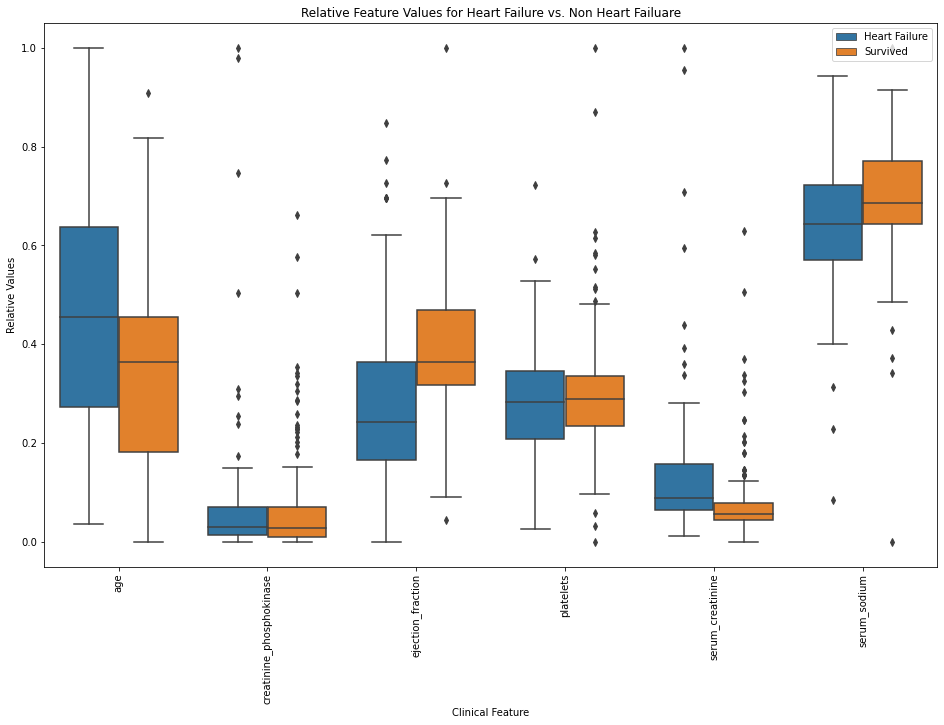

In [20]:
#Plot the distributions with boxplots
plt.subplots(figsize=(16,10))
sns.boxplot(x='Clinical_Feature',y='Relative_Value',hue='DEATH_EVENT',data=df_metled)
plt.xticks(rotation='vertical')
plt.ylabel('Relative Values')
plt.xlabel('Clinical Feature')
plt.title('Relative Feature Values for Heart Failure vs. Non Heart Failuare')
plt.legend(loc='upper right')
plt.show()

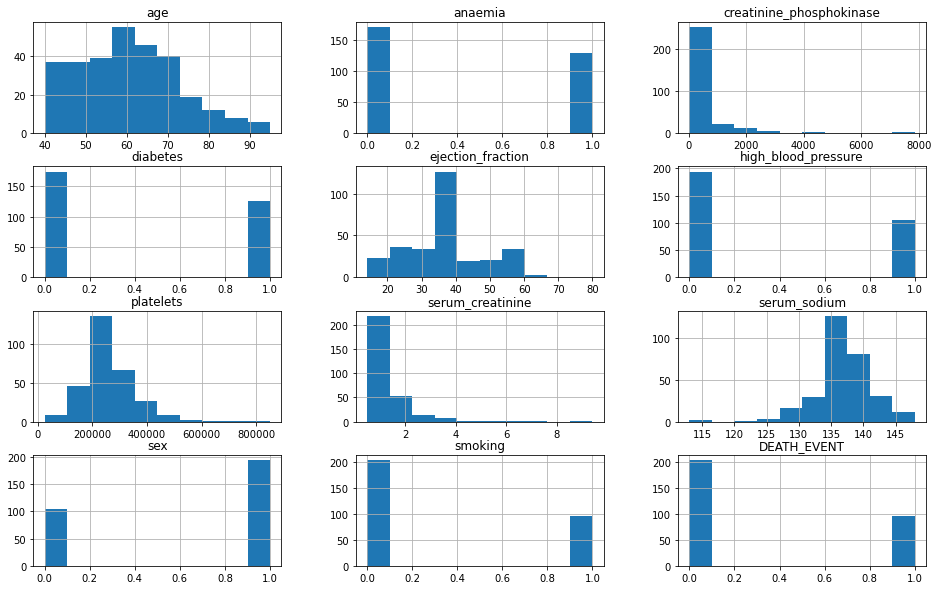

In [21]:
df.hist(figsize=(16,10))
plt.show()

In [22]:
list2=['creatinine_phosphokinase','serum_creatinine','platelets','ejection_fraction','serum_sodium']
def log_trans_columns(df,list_):
    for feature in list_:
        a=np.array(df[feature]).reshape(-1, 1)
        pow_trans = PowerTransformer()
        q=pow_trans.fit_transform(a)
        df[feature]=q
    return df

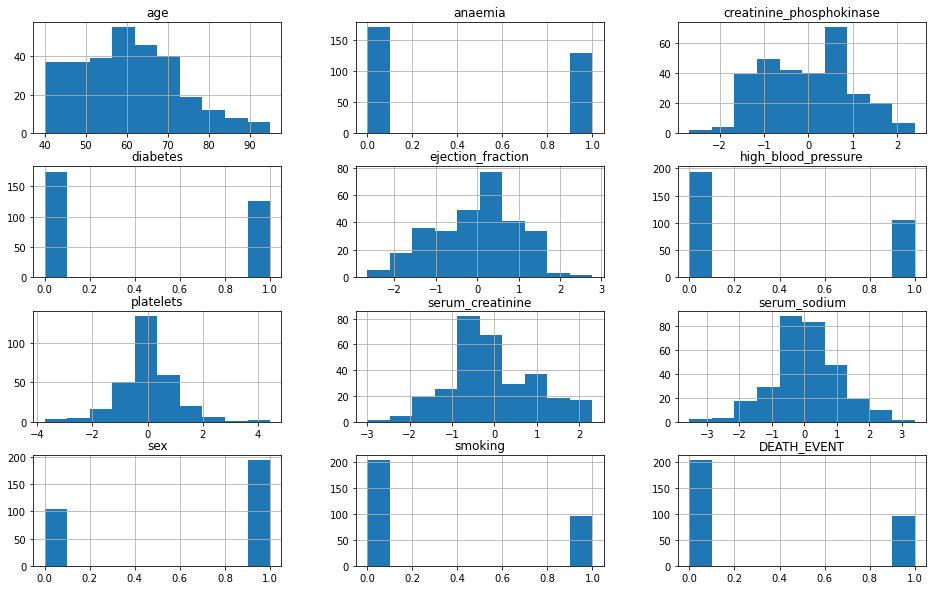

In [23]:
log_trans_columns(df,list2).hist(figsize=(16,10))
plt.show()

In [24]:
df=log_trans_columns(df,list2)

In [25]:
X=df.drop(columns=['DEATH_EVENT'])
y=df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=30,stratify=y)

# Logisitic Regression

In [26]:
#Find optimal logsistic regression parameter
clf = LogisticRegression(random_state=42,max_iter=1000)
C=[0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38]
distributions = {'C': C}
LR_RS=GridSearchCV(clf, distributions,n_jobs=-1,scoring='f1')
search_clf=LR_RS.fit(X_train, y_train)
best_dict=search_clf.best_params_
search_clf.best_params_

{'C': 0.3}

In [27]:
clf=LogisticRegression(random_state=42,C=0.31,max_iter=1000)
clf.fit(X_train,y_train)

LogisticRegression(C=0.31, max_iter=1000, random_state=42)

In [28]:
print(confusion_matrix(y_train,clf.predict(X_train)))

[[135  17]
 [ 34  38]]


In [29]:
print(classification_report(y_train,clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       152
           1       0.69      0.53      0.60        72

    accuracy                           0.77       224
   macro avg       0.74      0.71      0.72       224
weighted avg       0.76      0.77      0.76       224



Best Threshold=0.360849, F-Score=0.667


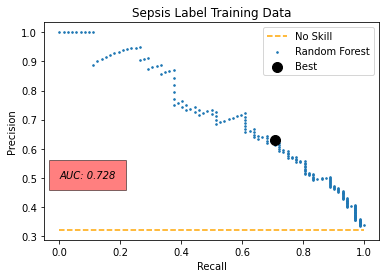

In [30]:
#Results for Training Set
yhat = clf.predict_proba(X_train)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train[y_train==1]) / len(y_train)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .5, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Training Data')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.367348, F-Score=0.583


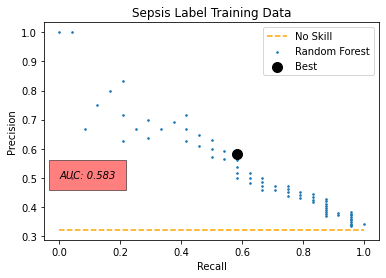

In [31]:
#Results for Test Set
yhat = clf.predict_proba(X_test)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train[y_train==1]) / len(y_train)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .5, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Training Data')
plt.legend()
# show the plot
plt.show()

In [ ]:
print(confusion_matrix(y_test,clf.predict(X_test)))

# Random Forest

In [34]:
RFC = RandomForestClassifier(random_state=42,max_features='sqrt',n_estimators=500)
max_depth = [i**2 for i in range (2,10)]
min_samples_split = [4,7,11,16]
min_samples_leaf = [4,7,11,16]
distributions = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
RFC_RS=GridSearchCV(RFC,distributions,n_jobs=-1,scoring='f1')
search_RFC_Sepsis=RFC_RS.fit(X_train, y_train)
search_RFC_Sepsis.best_params_

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 16}

In [35]:
best_dict=search_RFC_Sepsis.best_params_

In [38]:
RFC_=RandomForestClassifier(n_estimators=1000, min_samples_split=best_dict['min_samples_split'],
min_samples_leaf=best_dict['min_samples_leaf'], max_features='sqrt', max_depth=best_dict['max_depth'],
random_state=42,n_jobs=-1)
RFC_.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=16, n_estimators=1000, n_jobs=-1,
                       random_state=42)

Best Threshold=0.403729, F-Score=0.795


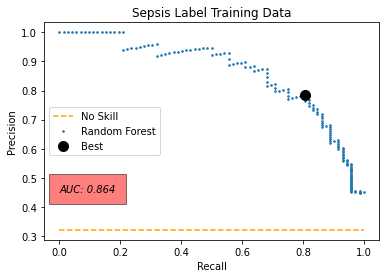

In [39]:
#Results for Training Set
yhat = RFC_.predict_proba(X_train)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train[y_train==1]) / len(y_train)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .45, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Training Data')
plt.legend()
# show the plot
plt.show()

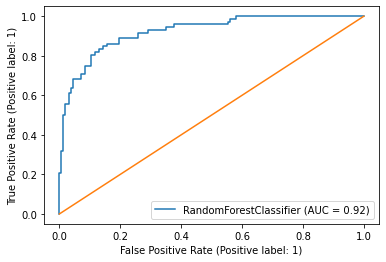

In [41]:
#Roc Curve for Training Set
plot_roc_curve(RFC_, X_train, y_train)  
plt.plot([0,1],[0,1])
plt.show()   

Best Threshold=0.687137, F-Score=nan


<ipython-input-40-7b591cb96c7e>:5: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


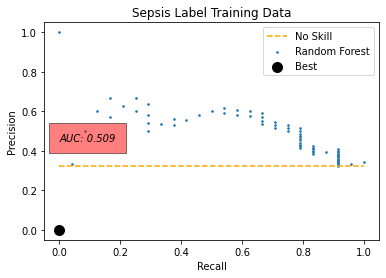

In [40]:
#Results for Test Set
yhat = RFC_.predict_proba(X_test)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train[y_train==1]) / len(y_train)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .45, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Training Data')
plt.legend()
# show the plot
plt.show()

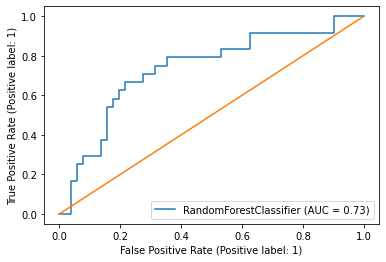

In [42]:
#Roc Curve for TestSet
plot_roc_curve(RFC_, X_test, y_test)  
plt.plot([0,1],[0,1])
plt.show()   

In [43]:
print(confusion_matrix(y_test,RFC_.predict(X_test)))

[[44  7]
 [17  7]]


# Adaboost

In [ ]:
#Find optimal random forest parameters for modelling Pre Sep 2
AB = AdaBoostClassifier(random_state=42)
n_estimators = [75,87,100,115,125,130]
learning_rate=[0.05,0.75,0.1,0.15,0.2]
distributions = {'n_estimators': n_estimators,'learning_rate': learning_rate}
AB_RS=GridSearchCV(AB,distributions,n_jobs=-1,scoring='f1')
search_AB=AB_RS.fit(X_train, y_train)
best_dict=search_AB.best_params_
search_AB.best_params_

In [ ]:
pd.DataFrame.from_dict(search_AB.cv_results_)

In [ ]:
#Create Model
AB_=AdaBoostClassifier(n_estimators=best_dict['n_estimators'], learning_rate=best_dict['learning_rate'], random_state=42)
AB_.fit(X_train,y_train)

In [ ]:
#Results for Training Set
yhat = AB_.predict_proba(X_train)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train[y_train==1]) / len(y_train)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .45, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P-R Curve Training Data')
plt.legend()
# show the plot
plt.show()

In [ ]:
#Roc Curve for Training Set
plot_roc_curve(AB_, X_train, y_train)  
plt.plot([0,1],[0,1])
plt.show()   

In [ ]:
print(classification_report(y_train,AB_.predict(X_train)))

In [ ]:
#Results for Test Set
yhat = AB_.predict_proba(X_test)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train[y_train==1]) / len(y_train)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .45, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P-R Curve Testing Data')
plt.legend()
# show the plot
plt.show()

In [ ]:
#Roc Curve for Test Set
plot_roc_curve(AB_, X_test, y_test)  
plt.plot([0,1],[0,1])
plt.show()   

In [ ]:
print(classification_report(y_test,AB_.predict(X_test)))

In [ ]:
print(confusion_matrix(y_test,AB_.predict(X_test)))